In [1]:
import pandas as pd
import os
import numpy as np
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

C:\Users\Luke1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("./data/IMDB Dataset.csv")
df.info()
df.describe() # there are duplicates
null_values = df.isnull().sum()
null_values.index[0]
print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
There are 0 missing values for review and 0 missing values for sentiment.


C:\Users\Luke1\AppData\Local\Temp\ipykernel_13768\113936211.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('There are {} missing values for {} and {} missing values for {}.'.format(null_values[0],null_values.index[0],null_values[1],null_values.index[1]))


In [3]:
review = df['review']
duplicated_review = df[review.isin(review[review.duplicated()])].sort_values("review")
df.drop_duplicates(inplace = True) # drop duplicates

In [4]:
# PARAMETERS to keep it short
SUBSET_SIZE = 1000        # sample from the 50k (change smaller if you need faster)
MAX_LENGTH = 128          # shorter sequences -> faster
BATCH_SIZE = 32           # larger batch reduces number of steps (watch RAM)
NUM_EPOCHS = 2            # just 1 epoch
LR = 5e-5

# 1) Stratified subset (from your existing `df` that has 'review' and 'sentiment')
#    (assumes sentiment values are 'positive'/'negative')
subset_df, _ = train_test_split(
    df, 
    train_size=SUBSET_SIZE, 
    stratify=df['sentiment'], 
    random_state=42
)

# 2) train/val split (stratified)
train_df, val_df = train_test_split(
    subset_df,
    test_size=0.2,
    stratify=subset_df['sentiment'],
    random_state=42
)

# 3) tokenizer & encodings
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_enc = tokenizer(
    train_df['review'].tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)
val_enc = tokenizer(
    val_df['review'].tolist(),
    truncation=True,
    padding=True,
    max_length=MAX_LENGTH,
    return_tensors='pt'
)

# 4) labels -> tensors (0/1)
label_map = {'negative': 0, 'positive': 1}
train_labels = torch.tensor(train_df['sentiment'].map(label_map).tolist())
val_labels   = torch.tensor(val_df['sentiment'].map(label_map).tolist())


In [5]:

# 5) Dataset wrapper
class EncodedDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_ds = EncodedDataset(train_enc, train_labels.long())
val_ds   = EncodedDataset(val_enc, val_labels.long())

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

# 6) model, optimizer, device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)
optimizer = AdamW(model.parameters(), lr=LR)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 — train loss: 0.5944 — train acc: 0.6837 | val loss: 0.3759 — val acc: 0.8450
Epoch 2 — train loss: 0.3638 — train acc: 0.8650 | val loss: 0.3475 — val acc: 0.8650
Fine-tuned DistilBERT Results:
Accuracy:  0.8650
Precision: 0.8687
Recall:    0.8600
F1-score:  0.8643


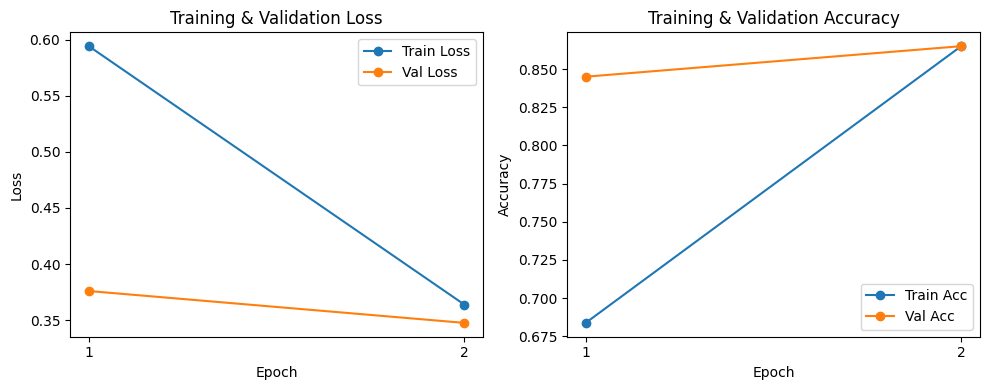

In [6]:

# containers for metrics
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    total_train_correct = 0
    total_train_examples = 0
    train_steps = 0

    for batch in train_loader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        # accumulate training stats
        total_loss += loss.item()
        train_steps += 1

        preds = torch.argmax(logits, dim=1)
        total_train_correct += (preds == labels).sum().item()
        total_train_examples += labels.size(0)

    avg_train_loss = total_loss / train_steps if train_steps else 0.0
    train_accuracy = total_train_correct / total_train_examples if total_train_examples else 0.0
    train_losses.append(avg_train_loss)
    train_accs.append(train_accuracy)

    # validation
    model.eval()
    val_loss = 0.0
    val_steps = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_steps += 1

            preds = outputs.logits.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_loss / val_steps if val_steps else 0.0
    val_accuracy = val_correct / val_total if val_total else 0.0
    val_losses.append(avg_val_loss)
    val_accs.append(val_accuracy)

    print(f"Epoch {epoch} — train loss: {avg_train_loss:.4f} — train acc: {train_accuracy:.4f} | "
          f"val loss: {avg_val_loss:.4f} — val acc: {val_accuracy:.4f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Compute metrics ---
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Fine-tuned DistilBERT Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

# --- Plotting ---
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(10,4))

# Loss subplot
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.xticks(epochs)
plt.legend()

# Accuracy subplot
plt.subplot(1,2,2)
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs, marker='o', label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.xticks(epochs)
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):\n", cm)




Confusion matrix (rows=true, cols=pred):
 [[87 13]
 [14 86]]


In [8]:
# pretrained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_encodings = val_enc
test_labels = val_labels
# --- Create dataloader for test set (same batching as validation earlier) ---
val_dataset = EncodedDataset(test_encodings, test_labels.long())
val_loader  = DataLoader(val_dataset, batch_size=32, shuffle=False)

# --- Load pre-trained DistilBERT classification model (no fine-tuning) ---
# Note: classification head will be the default untrained head when num_labels=2
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)
model.eval()

# --- Evaluate (no gradient updates) ---
total_loss = 0.0
steps = 0
correct = 0
total = 0

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()
        steps += 1

        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_val_loss = total_loss / steps if steps else 0.0
val_accuracy = correct / total if total else 0.0

print(f"Pretrained (no fine-tune) — Val loss: {avg_val_loss:.4f} — Val accuracy: {val_accuracy:.4f}")

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Compute metrics ---
acc = accuracy_score(y_true, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')

print(f"Pretrained DistilBERT Results:")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pretrained (no fine-tune) — Val loss: 0.6937 — Val accuracy: 0.4900
Pretrained DistilBERT Results:
Accuracy:  0.4900
Precision: 0.4940
Recall:    0.8200
F1-score:  0.6165


In [18]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# --- Compute and print confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix (rows=true, cols=pred):")
print(cm)

Confusion matrix (rows=true, cols=pred):
[[ 2 98]
 [ 1 99]]


In [19]:
# Classical MOdel (Logistic Regression)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})
# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    df['review'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=42
)

# TF-IDF features
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Logistic Regression
clf = LogisticRegression(max_iter=200)
clf.fit(X_train_tfidf, y_train)

# Evaluation
y_pred = clf.predict(X_test_tfidf)
acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

cm = confusion_matrix(y_test, y_pred)
print("\nConfusion matrix (rows=true, cols=pred):")
print(cm)

Accuracy: 0.8901
Precision: 0.8783
Recall: 0.9066
F1-score: 0.8922

Confusion matrix (rows=true, cols=pred):
[[4315  625]
 [ 465 4512]]
